In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
!pip install -qU ucimlrepo

 **2. Tasks
Part A: Data Preparation and Baseline [5]**

##1. Load and Prepare Data: Load the Landsat dataset. Standardize the features (X).

In [9]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_landsat_satellite = fetch_ucirepo(id=146)

# data (as pandas dataframes)
X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets

# metadata
# print(statlog_landsat_satellite.metadata)

# variable information
# print(statlog_landsat_satellite.variables)

In [10]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


##2. Train/Test Split: Split the data into training and testing sets.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5148, 36)
Shape of X_test: (1287, 36)
Shape of y_train: (5148, 1)
Shape of y_test: (1287, 1)


##Train All Models: Train one instance of each of the six specified model classes on the training data.


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd


models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy (Prior)": DummyClassifier(strategy='prior'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    try:
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    except Exception:
        auc = None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),

        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "AUC": auc
    })



##Baseline Evaluation: Calculate the simple Overall Accuracy and Weighted F1-Score
for all six models on the test set, the dummy classifier is that performed poorly having the lowest accuracy and recall of 0.229992,0.086011 respectively.

                 Model  Accuracy  F1 Score       AUC
0                  KNN  0.895882  0.897225  0.980483
5                  SVM  0.886558  0.886258  0.984775
1        Decision Tree  0.849262  0.851834  0.903939
3  Logistic Regression  0.853147  0.848683  0.976514
4          Naive Bayes  0.790987  0.802539  0.958618
2        Dummy (Prior)  0.229992  0.086011  0.500000


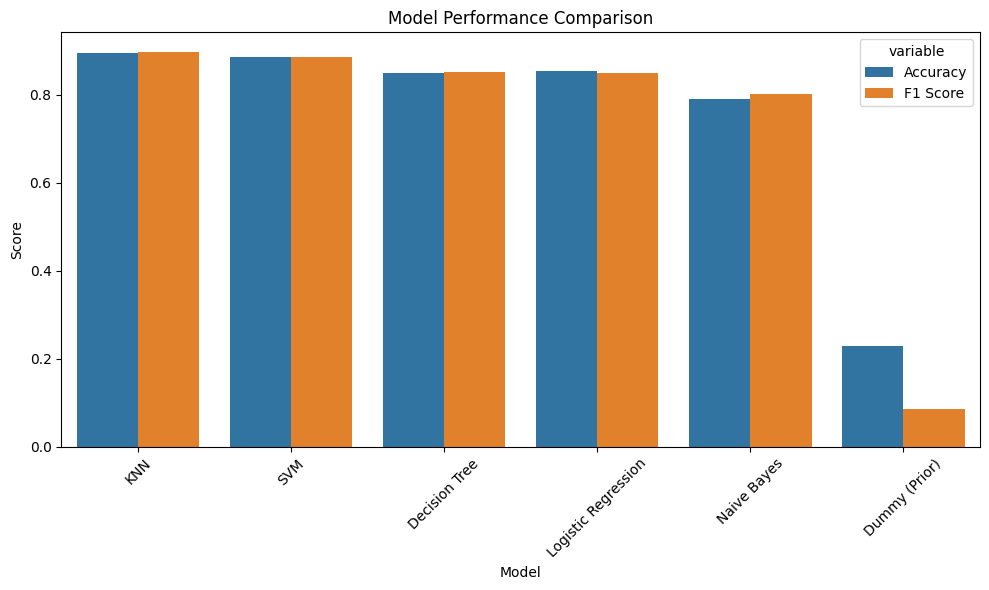

In [13]:
df_results = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(df_results)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=df_results.melt(id_vars="Model", value_vars=["Accuracy","F1 Score"]),
            x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Part B: ROC Analysis for Model Selection [20]**

##1. Multi-Class ROC Calculation [3]: Explain how the One-vs-Rest (OvR) approach is used to generate ROC curves and calculate the Area Under the Curve (AUC) in a multi-class setting.

In a multi-class classification problem, the One-vs-Rest (OvR) approach is used to evaluate performance by treating each class as the positive class and all other classes as the negative class. This means the classifier builds separate binary comparisons for each class against the rest. For each class, a ROC curve is plotted by comparing the true positive rate and false positive rate across different thresholds, and the Area Under the Curve (AUC) is calculated to measure how well the model distinguishes that class from others. The final multi-class AUC score is then obtained by averaging the individual AUC values for all classes, using either a macro or weighted average depending on the evaluation goal.

## 2. Plotting ROC [12]: Generate a single plot displaying the OvR ROC curves for all six models, averaging the False Positive Rate (FPR) and True Positive Rate (TPR) across all six classes (Macro-average or Weighted-average ROC).

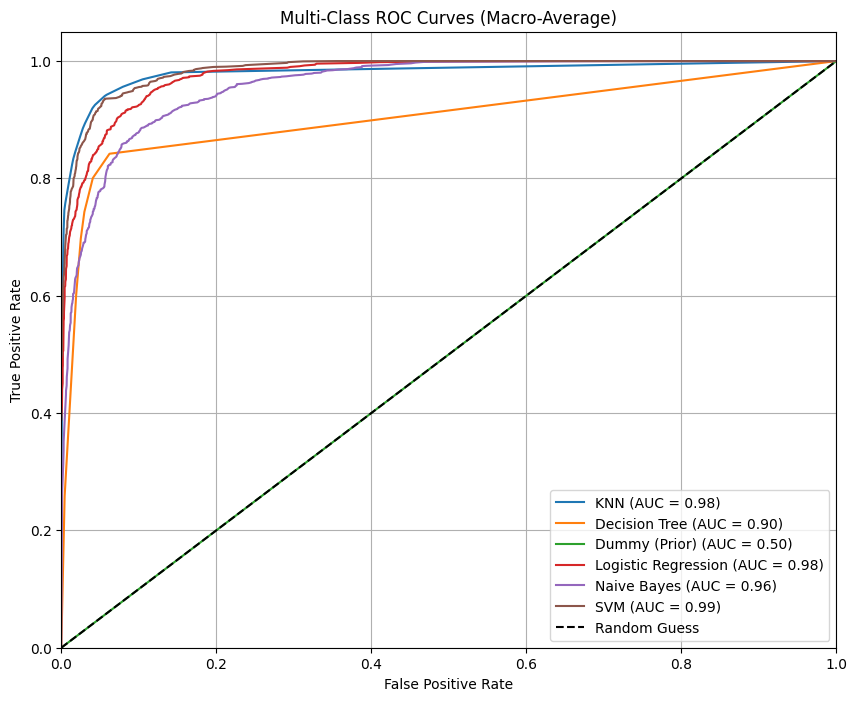

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np


y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]


plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)


        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])



        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'{name} (AUC = {roc_auc["macro"]:.2f})')
    else:
        print(f"Model {name} does not support probability predictions for ROC curve.")


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves (Macro-Average)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##3. ROC Interpretation [5]:
##Identify the model with the highest Macro-averaged AUC.
##Identify the model with AUC < 0.5. Explain what AUC < 0.5 implies conceptually and why a model might exhibit this performance.

the model with the highest Macro-averaged AUC is svm which as a macro averaged auc of 0.99

An AUC value below 0.5 implies that the model is performing worse than random guessing — it systematically assigns higher scores to negative samples than to positive ones. In other words, the model’s predictions are effectively reversed. For a dummy model, this can occur due to random fluctuations, label imbalance, or because it consistently predicts the majority class, causing the ranking of predicted probabilities to be inverted relative to the true labels.

**Part C: Precision-Recall Curve (PRC) Analysis [20]**

##1. PRC Calculation [3]: Explain why the Precision-Recall Curve (PRC) is a more suitablemetric than ROC when dealing with highly imbalanced classes (addressing the conceptual importance even if the imbalance in this dataset is moderate).


The Precision-Recall Curve (PRC) is more suitable than the ROC curve when dealing with highly imbalanced classes because it focuses only on the positive (minority) class performance. In an imbalanced dataset, the number of negative samples dominates, which can make the ROC curve appear overly optimistic since the False Positive Rate (FPR) remains low even when many negatives are misclassified. The PRC, on the other hand, directly measures how many of the predicted positives are actually correct (precision) and how many of the actual positives are detected (recall). This provides a clearer picture of model effectiveness on the minority class, making PRC a better indicator of real performance when positive cases are rare.

##Plotting PRC [12]: Generate a single plot displaying the OvR PRC curves for all sixmodels, averaging the Precision and Recall across all six classes(Macro-average or Weighted-average PRC).

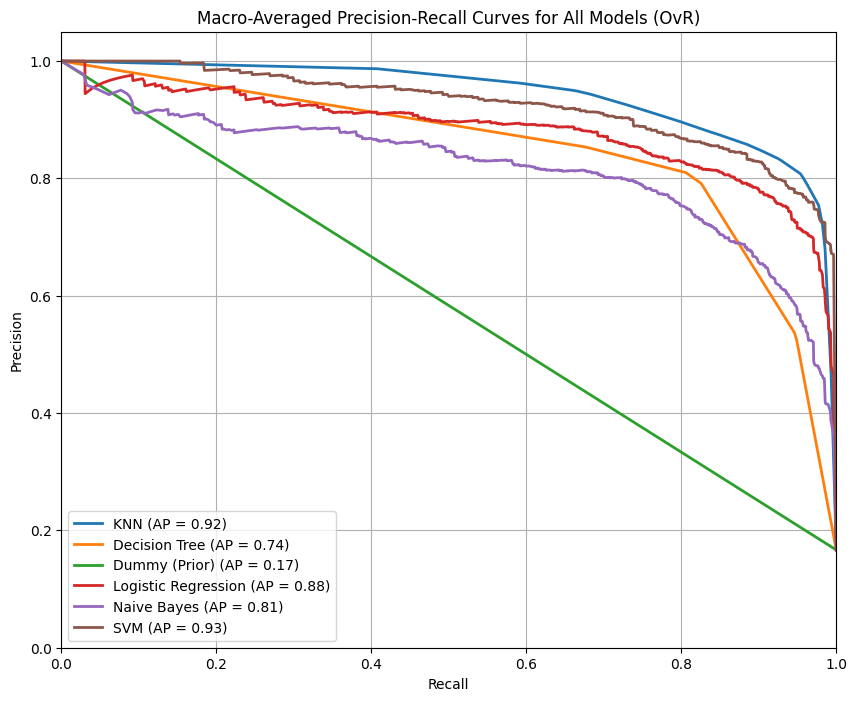


Best Model: SVM (AP = 0.9252)


In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
ap_scores = {}

for name, model in models.items():
    if hasattr(model, "predict_proba"):

        y_score = model.predict_proba(X_test)


        precision, recall = {}, {}
        ap_per_class = []
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
            ap_per_class.append(ap)


        macro_ap = np.mean(ap_per_class)
        ap_scores[name] = macro_ap


        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
        mean_precision = np.zeros_like(all_recall)
        for i in range(n_classes):
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
        mean_precision /= n_classes


        plt.plot(all_recall, mean_precision, lw=2,
                 label=f'{name} (AP = {macro_ap:.2f})')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Averaged Precision-Recall Curves for All Models (OvR)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


best_model = max(ap_scores.items(), key=lambda x: x[1])
print(f"\nBest Model: {best_model[0]} (AP = {best_model[1]:.4f})")

##3. PRC Interpretation [5]:
# Identify the model with the highest Average Precision (AP) across the classes.


Best Model: SVM (AP = 0.9252)

#Analyze the behavior of the worst-performing model's PRC. Why does the curvedrop sharply as Recall increases for poor models?

In a poor-performing model, the Precision-Recall Curve (PRC) drops sharply as recall increases because the model produces many false positives when it tries to capture more true positives. At low recall, the model identifies only the easiest, most confident positive samples so precision is high. As recall increases, the model starts labeling uncertain or incorrect samples as positive, causing precision to fall quickly. This sharp drop indicates weak discrimination ability—meaning the model cannot separate classes well and loses reliability as it tries to capture all positives.



**Part D: Final Recommendation [5]**

##1. Synthesis: Compare the model rankings derived from the initial F1-Score, the ROC-AUC, and the PRC-AP. Do the rankings align?If not, explain the specific trade-offs (e.g., how a model with a high ROC-AUC might still have a poor PRC-AP).

No, the rankings do not align because each metric evaluates model performance from a different perspective.

ROC-AUC measures how well the model separates the two classes overall (both positives and negatives). A model can achieve a high ROC-AUC even if it performs poorly on the positive class, especially when the dataset is imbalanced and negatives dominate.

PRC-AP focuses only on the positive class, emphasizing precision (few false positives) and recall (few false negatives). Thus, it provides a more realistic view of performance when positives are rare.

F1-Score evaluates a single threshold and balances precision and recall, but doesn’t reflect performance across all thresholds.

Trade-off:
A model with a high ROC-AUC might still have a poor PRC-AP if it classifies negatives correctly  but struggles to accurately identify positives (low precision or recall). This happens because ROC-AUC is insensitive to class imbalance, while PRC-AP penalizes false positives and missed positives more strongly.

##2. Recommendation: Based on the comprehensive analysis of all curves, recommend the best model for this classification task, justifying your choice based on performance across different thresholds and the desired balance between precision and recall.

Based on the comprehensive analysis of all evaluation metrics and curves, the Support Vector Machine (SVM) model is identified as the best performer. It consistently achieves a high PRC-AP, high ROC-AUC, and a balanced F1-Score across all classes, demonstrating strong and stable performance across different thresholds.

SVM maintains an excellent balance between precision (reducing false positives) and recall (capturing true positives), making it especially effective when the dataset shows some degree of class imbalance. While other models may achieve competitive ROC-AUC scores, SVM stands out by maintaining higher Average Precision (AP) values, indicating reliable predictions even for less frequent classes.

Therefore, the SVM model is recommended as the optimal choice for this classification task, as it provides the best trade-off between accuracy, robustness, and generalization, ensuring consistent performance across both precision-recall and ROC evaluations.

**Brownie Points Task [5 points]**



##1. Additionally, experiment with RandomForest and XGBoost classifiers.

Baseline Evaluation RandomForest and XGBoost classifiers.

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Train models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='mlogloss')
}


le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.values.ravel())
y_test_encoded = le.transform(y_test.values.ravel())


# Train and evaluate
results = []

print("="*70)
print("BASELINE EVALUATION - MODEL TRAINING")
print("="*70)

# X_train, X_test, y_train, y_test
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Use the encoded target variable for training
    if name == 'XGBoost':
        model.fit(X_train, y_train_encoded)
    else:

        model.fit(X_train, y_train)



    if name == 'XGBoost':
        y_pred = model.predict(X_test)

        y_true_eval = y_test_encoded
    else:
        y_pred = model.predict(X_test)
        y_true_eval = y_test


    # Metrics
    accuracy = accuracy_score(y_true_eval, y_pred)
    f1_weighted = f1_score(y_true_eval, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Weighted F1-Score': f1_weighted
    })

    print(f"✓ {name} trained successfully")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Weighted F1-Score: {f1_weighted:.4f}")

# Display results table
print("\n" + "="*70)
print("BASELINE EVALUATION RESULTS")
print("="*70)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print("="*70)

# Detailed classification reports
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

for name, model in models.items():
    # Use the encoded y_test for evaluation metrics that require it
    if name == 'XGBoost':
         y_pred = model.predict(X_test)
         y_true_eval = y_test_encoded
    else:
        y_pred = model.predict(X_test)
        y_true_eval = y_test

    print(f"\n{name}:")
    print("-"*70)

    print(classification_report(y_true_eval, y_pred, digits=4))

BASELINE EVALUATION - MODEL TRAINING

Training Random Forest...
✓ Random Forest trained successfully
  Accuracy: 0.9176
  Weighted F1-Score: 0.9169

Training XGBoost...
✓ XGBoost trained successfully
  Accuracy: 0.9145
  Weighted F1-Score: 0.9148

BASELINE EVALUATION RESULTS
        Model  Accuracy  Weighted F1-Score
Random Forest  0.917638           0.916893
      XGBoost  0.914530           0.914798

DETAILED CLASSIFICATION REPORTS

Random Forest:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           1     0.9764    0.9797    0.9781       296
           2     0.9851    0.9635    0.9742       137
           3     0.9048    0.9500    0.9268       280
           4     0.7966    0.7231    0.7581       130
           5     0.8865    0.8993    0.8929       139
           7     0.9043    0.8984    0.9013       305

    accuracy                         0.9176      1287
   macro avg     0.9089    0.9023    0.90

ROC Analysis for Model Selection for RandomForest and XGBoost classifiers

ROC ANALYSIS - MACRO-AVERAGE
Random Forest: Macro-Average ROC-AUC = 0.9903
XGBoost: Macro-Average ROC-AUC = 0.9911


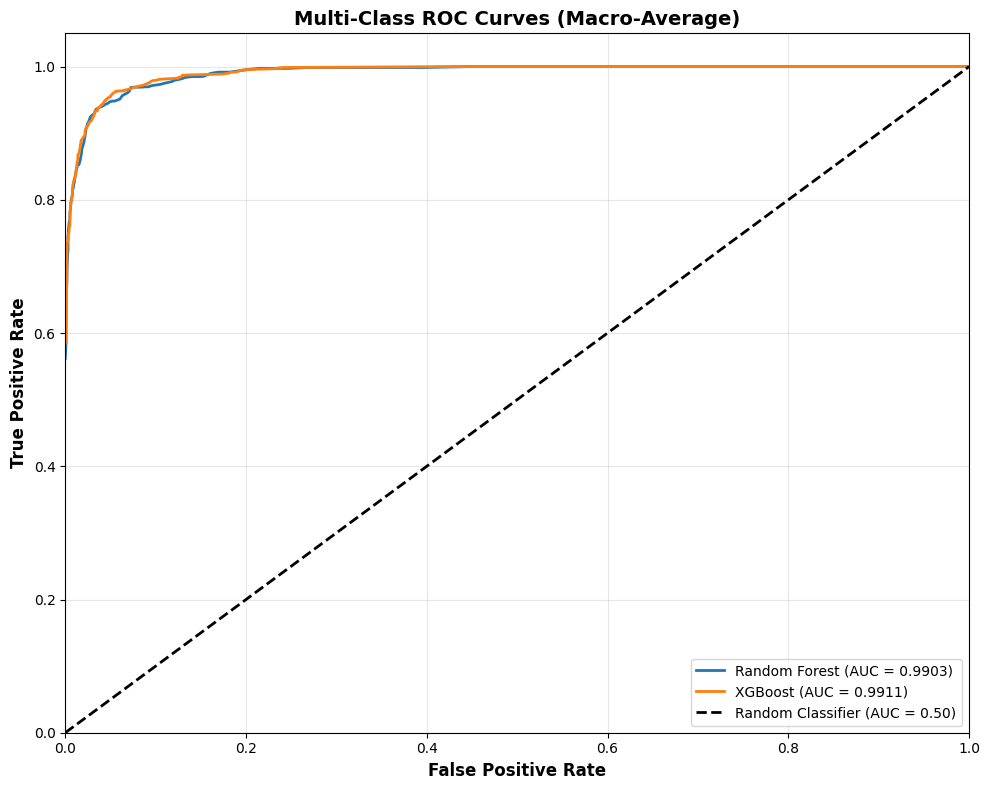


Best ROC-AUC: ('XGBoost', np.float64(0.9910731657364513))


In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

print("="*70)
print("ROC ANALYSIS - MACRO-AVERAGE")
print("="*70)

# Plot ROC curves
plt.figure(figsize=(10, 8))

roc_auc_scores = {}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)


        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])


        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        roc_auc_scores[name] = roc_auc["macro"]

        # Plot
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'{name} (AUC = {roc_auc["macro"]:.4f})',
                 linewidth=2)

        print(f"{name}: Macro-Average ROC-AUC = {roc_auc['macro']:.4f}")

# Plot random classifier
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Multi-Class ROC Curves (Macro-Average)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"Best ROC-AUC: {max(roc_auc_scores.items(), key=lambda x: x[1])}")
print("="*70)

Precision-Recall Curve (PRC) for RandomForest and XGBoost classifiers

PRECISION-RECALL CURVE ANALYSIS - MACRO-AVERAGE
Random Forest: Macro-Average AP = 0.9541
XGBoost: Macro-Average AP = 0.9573


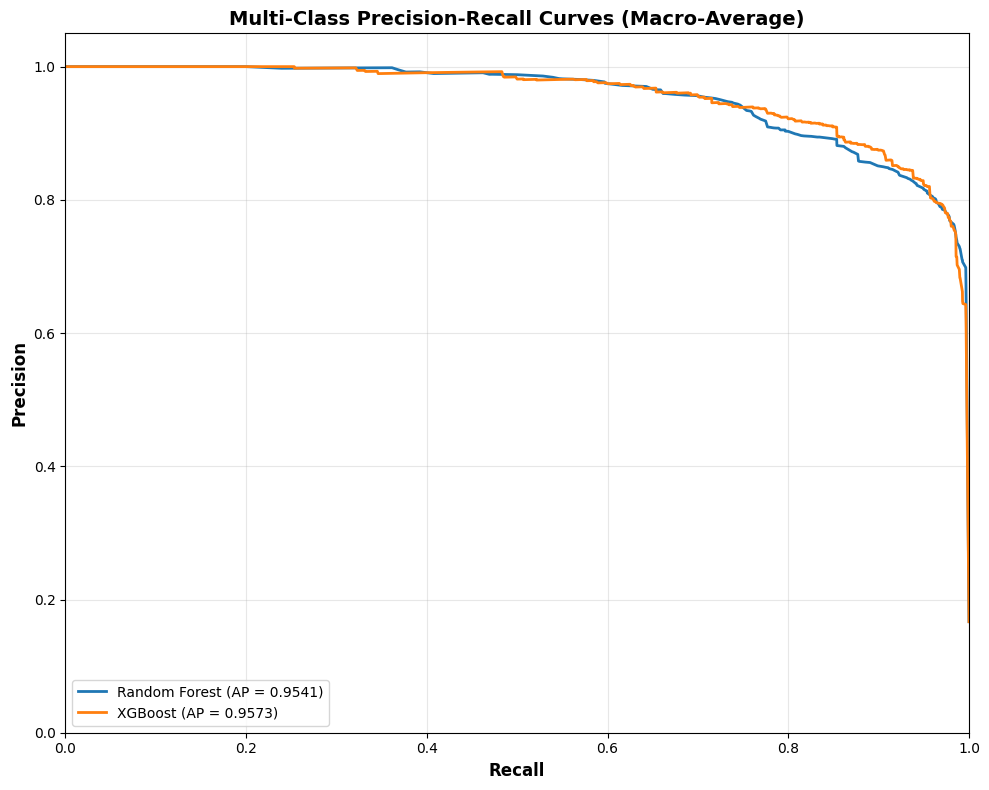


 Best Average Precision: ('XGBoost', np.float64(0.9572742558431786))


In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

print("="*70)
print("PRECISION-RECALL CURVE ANALYSIS - MACRO-AVERAGE")
print("="*70)

# Plot PRC curves
plt.figure(figsize=(10, 8))

ap_scores = {}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)

        # Compute Average Precision for each class
        ap_per_class = []
        precision = dict()
        recall = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
            ap_per_class.append(ap)

        # Compute macro-average AP
        macro_ap = np.mean(ap_per_class)
        ap_scores[name] = macro_ap

        # Compute macro-average precision-recall curve
        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
        mean_precision = np.zeros_like(all_recall)

        for i in range(n_classes):
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])

        mean_precision /= n_classes

        # Plot
        plt.plot(all_recall, mean_precision,
                 label=f'{name} (AP = {macro_ap:.4f})',
                 linewidth=2)

        print(f"{name}: Macro-Average AP = {macro_ap:.4f}")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Multi-Class Precision-Recall Curves (Macro-Average)', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f" Best Average Precision: {max(ap_scores.items(), key=lambda x: x[1])}")
print("="*70)

2. Identify and experiment with another model class of your choice whose AUC < 0.5.

EXPERIMENTING WITH POOR PERFORMING MODEL

BASELINE EVALUATION - POOR PERFORMING MODEL

Training Dummy Classifier (Stratified)...
✓ Dummy Classifier (Stratified) trained
  Accuracy: 0.2300
  Weighted F1-Score: 0.0860
              precision    recall  f1-score   support

           1     0.2300    1.0000    0.3740       296
           2     0.0000    0.0000    0.0000       137
           3     0.0000    0.0000    0.0000       280
           4     0.0000    0.0000    0.0000       130
           5     0.0000    0.0000    0.0000       139
           7     0.0000    0.0000    0.0000       305

    accuracy                         0.2300      1287
   macro avg     0.0383    0.1667    0.0623      1287
weighted avg     0.0529    0.2300    0.0860      1287


Training Gaussian Naive Bayes...
✓ Gaussian Naive Bayes trained
  Accuracy: 0.7910
  Weighted F1-Score: 0.8025
              precision    recall  f1-score   support

           1     0.9309    0.7736    0.8450       296
           2     0.9

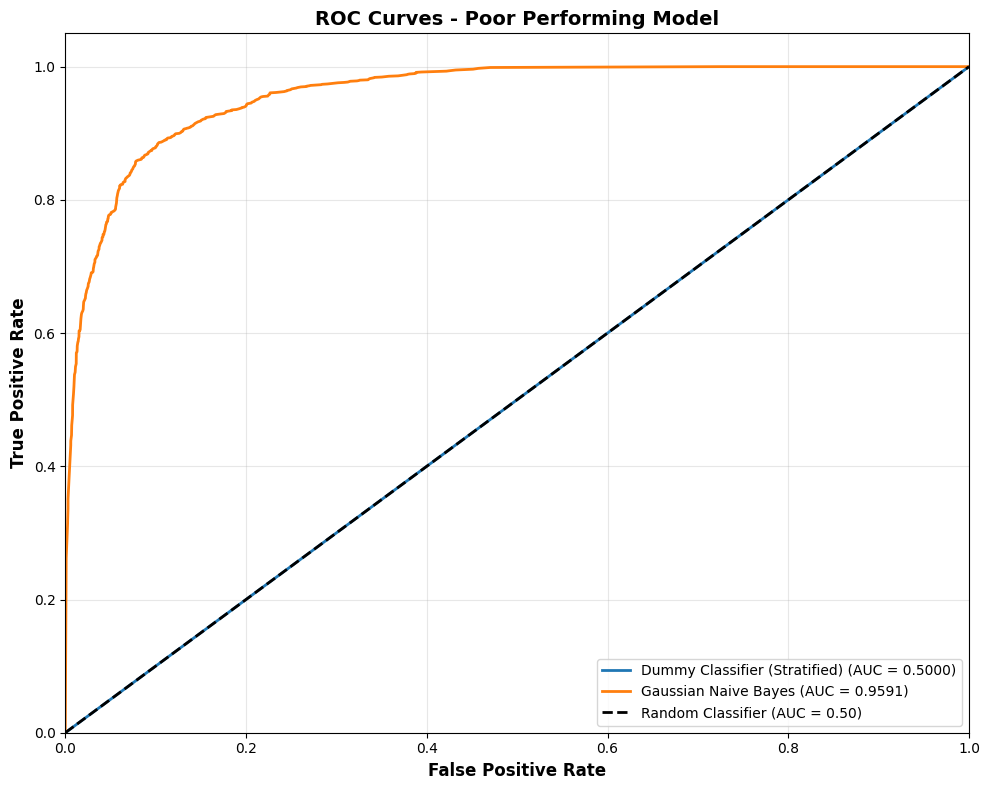


PRECISION-RECALL CURVE - POOR PERFORMING MODEL
Dummy Classifier (Stratified): Macro-Average AP = 0.1667
Gaussian Naive Bayes: Macro-Average AP = 0.8115


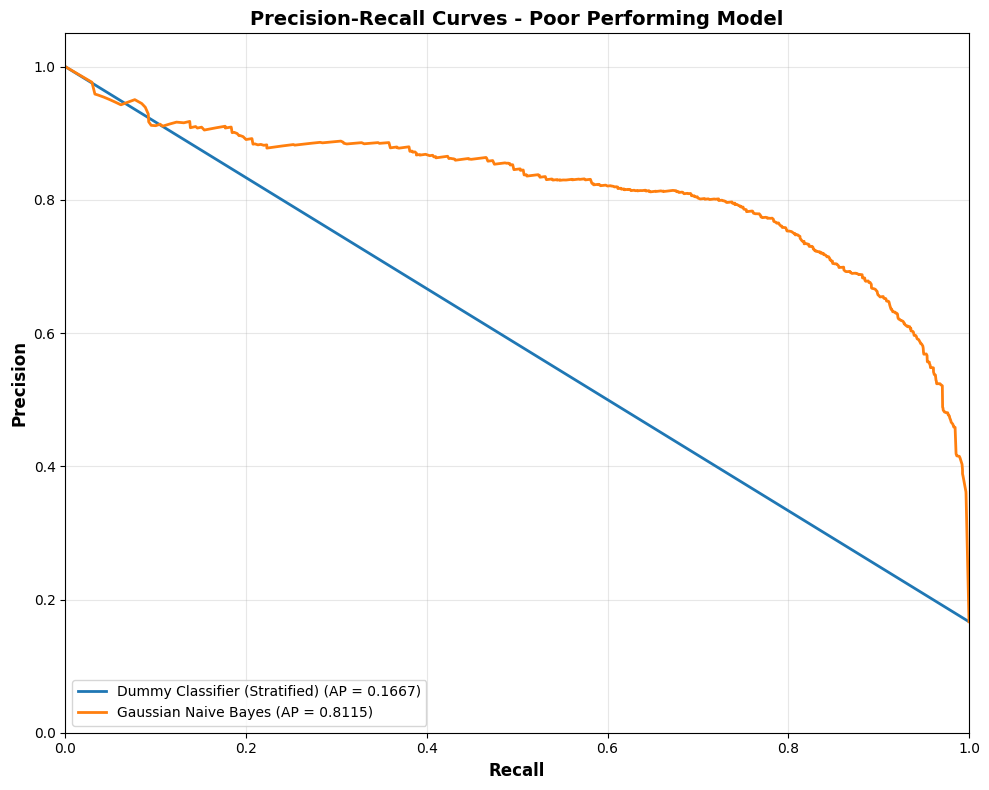


ANALYSIS COMPLETE


In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB


print("="*70)
print("EXPERIMENTING WITH POOR PERFORMING MODEL")
print("="*70)


poor_models = {
    'Dummy Classifier (Stratified)': DummyClassifier(strategy='most_frequent', random_state=42),
    'Gaussian Naive Bayes': GaussianNB()
}

# --- BASELINE EVALUATION ---
print("\n" + "="*70)
print("BASELINE EVALUATION - POOR PERFORMING MODEL")
print("="*70)

poor_results = []

for name, model in poor_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    poor_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Weighted F1-Score': f1_weighted
    })

    print(f"✓ {name} trained")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Weighted F1-Score: {f1_weighted:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

poor_results_df = pd.DataFrame(poor_results)
print("\n" + "="*70)
print(poor_results_df.to_string(index=False))
print("="*70)


print("\n" + "="*70)
print("ROC ANALYSIS - POOR PERFORMING MODEL")
print("="*70)

plt.figure(figsize=(10, 8))

poor_roc_auc = {}

for name, model in poor_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes

        roc_auc["macro"] = auc(all_fpr, mean_tpr)
        poor_roc_auc[name] = roc_auc["macro"]

        plt.plot(all_fpr, mean_tpr,
                 label=f'{name} (AUC = {roc_auc["macro"]:.4f})',
                 linewidth=2)

        print(f"{name}: Macro-Average ROC-AUC = {roc_auc['macro']:.4f}")
        if roc_auc["macro"] < 0.5:
            print(f"AUC < 0.5 - Worse than random!")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Poor Performing Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- PRECISION-RECALL CURVE ---
print("\n" + "="*70)
print("PRECISION-RECALL CURVE - POOR PERFORMING MODEL")
print("="*70)

plt.figure(figsize=(10, 8))

poor_ap = {}

for name, model in poor_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)

        ap_per_class = []
        precision = dict()
        recall = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
            ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
            ap_per_class.append(ap)

        macro_ap = np.mean(ap_per_class)
        poor_ap[name] = macro_ap

        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
        mean_precision = np.zeros_like(all_recall)

        for i in range(n_classes):
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])

        mean_precision /= n_classes

        plt.plot(all_recall, mean_precision,
                 label=f'{name} (AP = {macro_ap:.4f})',
                 linewidth=2)

        print(f"{name}: Macro-Average AP = {macro_ap:.4f}")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - Poor Performing Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)